In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
#data_subset_dir = "./Sub_Sub-set"
data_subset_dir = "./Caltech_256_Subset"

In [3]:
img_height = 200
img_len = 200

print("Training Dataset:")
training_ds = tf.keras.utils.image_dataset_from_directory(
    data_subset_dir, 
    image_size=(img_height, img_len),
    subset="training",
    validation_split=0.2,
    seed=1)

print("\nValidation Dataset:")
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_subset_dir, 
    image_size=(img_height, img_len),
    subset="validation",
    validation_split=0.2,
    seed=1)

Training Dataset:
Found 1280 files belonging to 7 classes.
Using 1024 files for training.

Validation Dataset:
Found 1280 files belonging to 7 classes.
Using 256 files for validation.


In [4]:
class_names = training_ds.class_names
print(class_names)

['058.doorknob', '070.fire-extinguisher', '071.fire-hydrant', '072.fire-truck', '126.ladder', '159.people', '253.faces-easy-101']


In [5]:
training_ds = training_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
num_classes = len(class_names)

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_len,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

In [8]:
augmented_train_ds = training_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


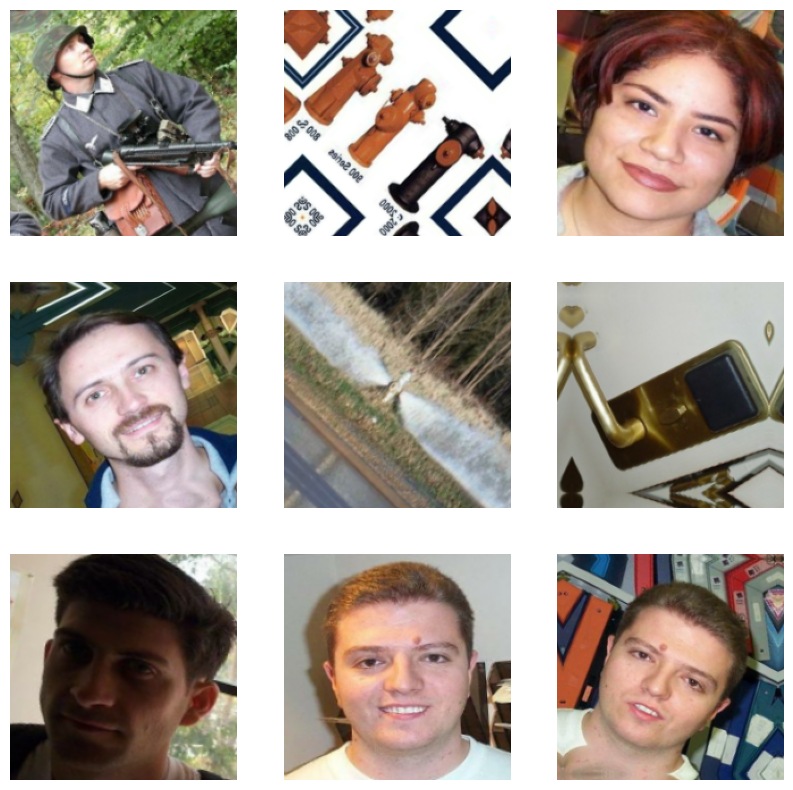

In [9]:
plt.figure(figsize=(10, 10))
for augmented_images, _ in augmented_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")

In [10]:
augmented_train_ds = augmented_train_ds.prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf.data.AUTOTUNE)

In [19]:
model = Sequential([
    # data_augmentation,
    layers.Rescaling(1./127.5, input_shape=(img_height, img_len, 3)),
    layers.Conv2D(100, 3, strides=2, padding='same', kernel_initializer='lecun_normal', activation='selu', bias_initializer='zeros'),
    # layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(50, 3, padding='same', kernel_initializer='lecun_normal', activation='selu', bias_initializer='zeros'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.SeparableConv2D(25, 3, padding='same', activation='selu', bias_initializer='zeros'),
    #layers.AlphaDropout(0.05),
    #layers.Conv2D(64, 3, padding='same', kernel_initializer='lecun_normal', activation='selu', bias_initializer='zeros'),
    #layers.MaxPooling2D(),
    #layers.AlphaDropout(0.05),
    layers.Flatten(),
    layers.Dense(64, kernel_initializer='lecun_normal', activation='selu', bias_initializer='zeros'),
    layers.BatchNormalization(),
    #layers.AlphaDropout(0.05),
    #layers.Dense(64, kernel_initializer='lecun_normal', activation='selu', bias_initializer='zeros'),
    layers.AlphaDropout(0.05),
    # layers.Dropout(0.2),
    # layers.Flatten(),
    layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'),
    layers.BatchNormalization(),
    layers.Dense(num_classes, name="outputs", activation="softmax")
])



In [20]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [21]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000001)
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.00005)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)

decay_sgd_optimizer = tf.keras.optimizers.SGD(learning_rate = lr_schedule)

model.compile(optimizer=decay_sgd_optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 100)     2800      
                                                                 
 batch_normalization_8 (Batc  (None, 100, 100, 100)    400       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 50)      45050     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 50)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 50, 50, 50)      

In [22]:
epochs = 30
history = model.fit(
  augmented_train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/30
32/32 [==============================] - 83s 3s/step - loss: 1.6044 - accuracy: 0.4619 - val_loss: 2.3051 - val_accuracy: 0.4453
Epoch 2/30
32/32 [==============================] - 80s 2s/step - loss: 1.2440 - accuracy: 0.5273 - val_loss: 1.5160 - val_accuracy: 0.5078
Epoch 3/30
32/32 [==============================] - 79s 2s/step - loss: 1.1547 - accuracy: 0.5713 - val_loss: 1.2116 - val_accuracy: 0.5742
Epoch 4/30
32/32 [==============================] - 78s 2s/step - loss: 1.0827 - accuracy: 0.6045 - val_loss: 1.0375 - val_accuracy: 0.6562
Epoch 5/30
32/32 [==============================] - 80s 3s/step - loss: 1.0466 - accuracy: 0.5889 - val_loss: 1.0658 - val_accuracy: 0.6289
Epoch 6/30
32/32 [==============================] - 81s 3s/step - loss: 0.9726 - accuracy: 0.6270 - val_loss: 1.1205 - val_accuracy: 0.5898
Epoch 7/30
32/32 [==============================] - 91s 3s/step - loss: 0.9476 - accuracy: 0.6348 - val_loss: 1.0020 - val_accuracy: 0.6055
Epoch 8/30
32/32 [==

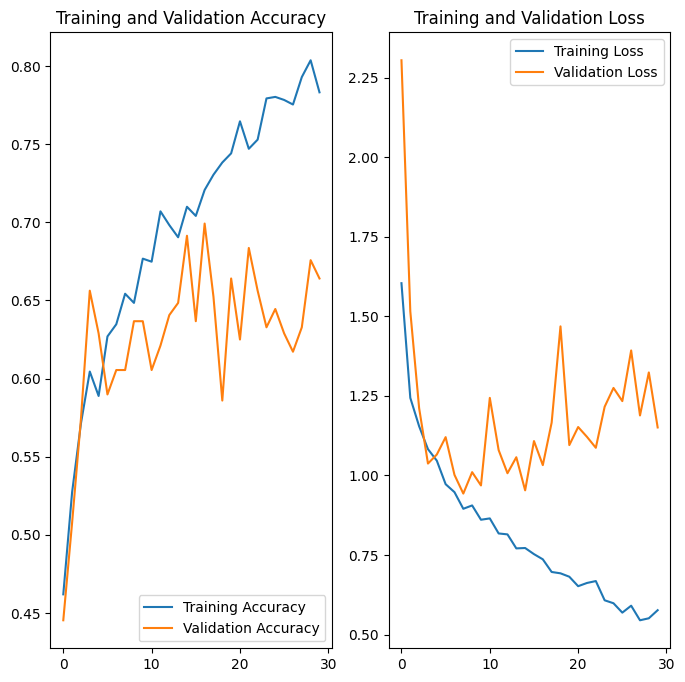

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
img = cv2.imread('fire_truck.jpg')
img = np.array(img)
predictions = model.predict(np.expand_dims(tf.image.resize(img, (200,200)),0))
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to '{}' with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 59ms/step
This image most likely belongs to '126.ladder' with a 26.78 percent confidence.


In [40]:
img = cv2.imread('072_0012.jpg')
img = np.array(img)
predictions = model.predict(np.expand_dims(tf.image.resize(img, (200,200)),0))
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to '{}' with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 64ms/step
This image most likely belongs to '072.fire-truck' with a 22.00 percent confidence.


In [25]:
img = cv2.imread('dry-powder-fire-extinguisher.jpeg')
img = np.array(img)
predictions = model.predict(np.expand_dims(tf.image.resize(img, (200,200)),0))
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to '{}' with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 56ms/step
This image most likely belongs to '126.ladder' with a 21.22 percent confidence.


In [26]:
img = cv2.imread('ladder.jpeg')
img = np.array(img)
predictions = model.predict(np.expand_dims(tf.image.resize(img, (200,200)),0))
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to '{}' with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 61ms/step
This image most likely belongs to '126.ladder' with a 30.10 percent confidence.


In [27]:
model.save('Model/CapstoneModel.h5')

In [28]:
loaded_model = tf.keras.models.load_model('Model/CapstoneModel.h5')

loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 100)     2800      
                                                                 
 batch_normalization_8 (Batc  (None, 100, 100, 100)    400       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 50)      45050     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 50)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 50, 50, 50)      

In [29]:
model.predict(np.expand_dims(tf.image.resize(img, (200,200)),0))


1/1 [==============================] - 0s 59ms/step


array([[1.1283538e-02, 3.1073654e-02, 1.1176217e-03, 6.7608795e-07,
        9.5634741e-01, 1.2823804e-04, 4.8824204e-05]], dtype=float32)

In [30]:
loaded_model.predict(np.expand_dims(tf.image.resize(img, (200,200)),0))

1/1 [==============================] - 0s 216ms/step


array([[1.1283538e-02, 3.1073654e-02, 1.1176217e-03, 6.7608795e-07,
        9.5634741e-01, 1.2823804e-04, 4.8824204e-05]], dtype=float32)